In [1]:
#Neural network program using Long Short Term Memory (LSTM) to predict future stock prices

In [2]:
#Download Libraries (Downloads libraries to your computer automatically)
'''import sys
!{sys.executable} -m pip install sklearn
!{sys.executable} -m pip install tensorflow
!{sys.executable} -m pip install pandas_datareader
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install keras
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install beautifulsoup4
!{sys.executable} -m pip install datetime'''

#Import Libraries (Import libraries to this program)
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from bs4 import BeautifulSoup as bs
import matplotlib.pyplot as plt
from datetime import datetime , timedelta
import seaborn as sns
plt.style.use('fivethirtyeight')

In [3]:
#Gather current date
today = datetime.today().strftime('%Y-%m-%d')
six_months_ago =  datetime.today() - timedelta(days = 252)
start_date = "2015-1-1"
future_date = datetime.today() + timedelta(days = 252)
future_date = future_date.strftime('%Y-%m-%d')
data = pd.DataFrame()

In [4]:
#Function to import stock data
def import_stock_data(tickers, start, end):
    data = pd.DataFrame()
    if len([tickers]) == 1:
        data[tickers] = web.DataReader(tickers, data_source='yahoo', start = start)['Adj Close']
        data = pd.DataFrame(data)
    else:
        for t in tickers:
            data[t] = web.DataReader(t, data_source='yahoo', start = start)['Adj Close']
    return(data)

2021-08-23


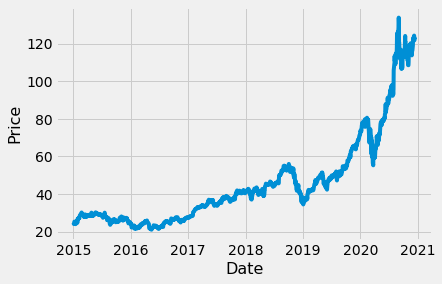

(1499, 1)

In [5]:
#List and plot stocks to research
ticker =['AAPL']
stocks_df = import_stock_data(ticker, start_date, today)
print(future_date)
plt.plot(stocks_df)
plt.xlabel('Date', fontsize = 16)
plt.ylabel('Price', fontsize = 16)
plt.show()

#Get the number of rows and columns
stocks_df.shape

#Convert stock data to numpy array
#clean_stocks_df = stocks_df.dropna()
#dataset = clean_stocks_df.values
#print(stocks_df[stocks_df.columns[2]])

In [6]:
#30 Day Simple Moving Average
def SMA_20(data):
    SMA_20 = data.rolling(window = 20).mean()
    SMA_20 = SMA_20.dropna()
    SMA_20 = pd.DataFrame(SMA_20)
    return SMA_20

#100 Day Simple Moving Average
def SMA_100(data):
    SMA_100 = data.rolling(window = 100).mean()
    SMA_100 = SMA_100.dropna()
    SMA_100 = pd.DataFrame(SMA_100)
    return SMA_100


In [7]:
#Function for the Long Short-Term Memory artificital recurrent neural network
def LSTM_model(df, batchsize, iterations, plot_prediction=True):
    clean_stocks_df = df.dropna()
    dataset = clean_stocks_df.values.reshape(-1,1)
    print(dataset)
    
    #Get 80% of the number of rows to train the model
    training_data_len = math.ceil(len(dataset) * .8)
    
    #Scale the data to apply preprocessing transformers to the imported data before implementing in neural network
    scaler = MinMaxScaler(feature_range = (0,1))
    scaled_data = scaler.fit_transform(dataset)
    
    #Create training dataset
    train_data = scaled_data[0:training_data_len , :]
    
    #Split the data into x_train and y_train data sets
    x_train = [] #x_train is independent variables, so date in this case
    y_train = [] #y_train is dependent variables, so price in this case
    
    for i in range(60, len(train_data)):
        x_train.append(train_data[i-60:i,0])
        y_train.append(train_data[i,0])
        
    #Convert the x_train and y_train to numpy arrays
    x_train, y_train = np.array(x_train), np.array(y_train)

    #Reshape the data
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    
    #Build the LSTM model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    
    #Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    #Train the model
    model.fit(x_train, y_train, batch_size=batchsize, epochs=iterations)
    
    #Create the testing data set
    test_data = scaled_data[training_data_len - 60:, :]

    #Create the data sets x_test and y_test to verify data
    x_test = []
    y_test = dataset[training_data_len:, :]
    for i in range(60, len(test_data)):
        x_test.append(test_data[i-60:i, 0])
        
    #Convert the data to a numpy array
    x_test = np.array(x_test)

    #Reshape the data
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    
    #Get the models predicted price values
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)
    
    #Get the Root Mean Squre Error (RMSE)
    rmse = np.sqrt(np.mean(predictions-y_test)**2)
    
    '''#### Future Predictions #####
    #Create the data sets x_test and y_test to predict future data
    x_future = []
    y_future = dataset[training_data_len:, :]
    for i in range(60, len(test_data)+252):
        x_future.append(test_data[i-60:i, 0])
        
    #Convert the data to a numpy array
    x_future = np.array(x_future)

    #Reshape the data
    x_future = np.reshape(x_future, (x_future.shape[0], x_future.shape[1], 1))
    
    #Get the models predicted price values
    predictions = model.predict(x_future)
    predictions = scaler.inverse_transform(predictions)'''
    
    '''#Plot the data
    if plot_prediction== True:
        train = stocks_df[:training_data_len]
        valid = stocks_df[training_data_len:]
        valid['Predictions']= predictions
        plt.title('Model')
        plt.xlabel('Date', fontsize=16)
        plt.ylabel('Close Price USD ($)', fontsize=16)
        plt.plot(train)
        plt.plot(valid)
        plt.legend(['Train', 'Validation','Predictions'], loc='upper left')
        plt.show()'''
    
    return predictions, rmse, training_data_len


In [8]:
#### Error with prediction values in graph. Index of 'Prediction' values does not have a designated date ####
#### Need to index the 'Prediction' values to match the index of 'Valid' values ###

'''#Show the valid and predicted prices
for i in range(0,len(stocks_df.columns)):
    predictions, rmse, training_data_len = LSTM_model(stocks_df[stocks_df.columns[i]], batchsize=1, iterations=1)
    predictions = pd.DataFrame(predictions)
    predictions.columns = ["Predictions"]
    print("Predictions:",predictions)
    train = stocks_df[stocks_df.columns[i]][:training_data_len]
    train = pd.DataFrame(train)
    train.columns = ["Train"]
    valid = stocks_df[stocks_df.columns[i]][training_data_len:]
    valid = pd.DataFrame(valid)
    valid.columns = ["Valid"]
    print("Train:",train)
    print("Valid:", valid)
    valid['Predictions']= predictions
    plt.title('Model')
    plt.xlabel('Date', fontsize=16)
    plt.ylabel('Close Price USD ($)', fontsize=16)
    plt.plot(train)
    plt.plot(valid)
    plt.plot(predictions)
    plt.legend(['Train', 'Validation','Predictions'], loc='upper left')
    plt.show()
    print(ticker[i])
    print(rmse)'''

'#Show the valid and predicted prices\nfor i in range(0,len(stocks_df.columns)):\n    predictions, rmse, training_data_len = LSTM_model(stocks_df[stocks_df.columns[i]], batchsize=1, iterations=1)\n    predictions = pd.DataFrame(predictions)\n    predictions.columns = ["Predictions"]\n    print("Predictions:",predictions)\n    train = stocks_df[stocks_df.columns[i]][:training_data_len]\n    train = pd.DataFrame(train)\n    train.columns = ["Train"]\n    valid = stocks_df[stocks_df.columns[i]][training_data_len:]\n    valid = pd.DataFrame(valid)\n    valid.columns = ["Valid"]\n    print("Train:",train)\n    print("Valid:", valid)\n    valid[\'Predictions\']= predictions\n    plt.title(\'Model\')\n    plt.xlabel(\'Date\', fontsize=16)\n    plt.ylabel(\'Close Price USD ($)\', fontsize=16)\n    plt.plot(train)\n    plt.plot(valid)\n    plt.plot(predictions)\n    plt.legend([\'Train\', \'Validation\',\'Predictions\'], loc=\'upper left\')\n    plt.show()\n    print(ticker[i])\n    print(rmse)

In [9]:
'''predictions_df= pd.DataFrame(predictions)
SMA_20_df = SMA_20(predictions_df)
#print(SMA_20_df)

SMA_100_df = SMA_100(predictions_df)
#print(SMA_100_df)

plt.plot(predictions_df)
plt.plot(SMA_20_df)
plt.plot(SMA_100_df)
plt.title('SMA Return Prediction')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Close Price USD ($)', fontsize=16)
plt.legend(['Price Prediction','20 Day SMA', '100 Day SMA'], loc='upper left')
plt.show()'''

"predictions_df= pd.DataFrame(predictions)\nSMA_20_df = SMA_20(predictions_df)\n#print(SMA_20_df)\n\nSMA_100_df = SMA_100(predictions_df)\n#print(SMA_100_df)\n\nplt.plot(predictions_df)\nplt.plot(SMA_20_df)\nplt.plot(SMA_100_df)\nplt.title('SMA Return Prediction')\nplt.xlabel('Date', fontsize=16)\nplt.ylabel('Close Price USD ($)', fontsize=16)\nplt.legend(['Price Prediction','20 Day SMA', '100 Day SMA'], loc='upper left')\nplt.show()"

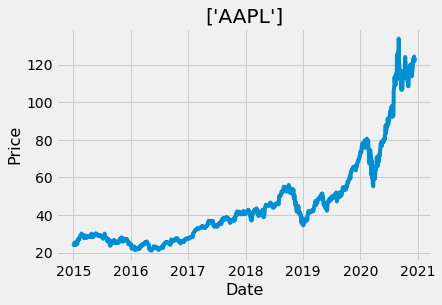

In [10]:
#Program to use the three moving average crossover strategy to determine when to buy and sell stock
stocks_df = import_stock_data(ticker, start_date, today)
plt.title(ticker)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Price', fontsize=16)
plt.plot(stocks_df)
plt.show()

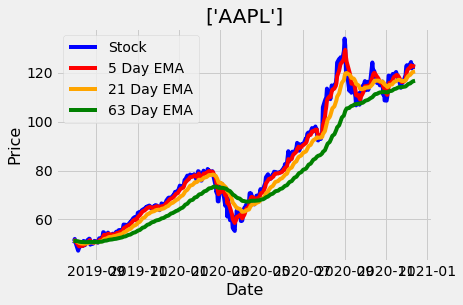

                  AAPL   Short EMA  Middle EMA    Long EMA
Date                                                      
2019-07-29   51.200279   51.200279   51.200279   51.200279
2019-07-30   50.980518   51.127026   51.180301   51.193412
2019-07-31   52.020744   51.424932   51.256705   51.219266
2019-08-01   50.895054   51.248306   51.223828   51.209134
2019-08-02   49.818211   50.771607   51.096044   51.165668
...                ...         ...         ...         ...
2020-12-08  124.379997  122.995686  119.638336  115.916314
2020-12-09  121.779999  122.590457  119.833033  116.099554
2020-12-10  123.239998  122.806970  120.142757  116.322693
2020-12-11  122.410004  122.674648  120.348870  116.512922
2020-12-14  122.305000  122.551432  120.526700  116.693924

[350 rows x 4 columns]


51.12702560424805

In [11]:
#Calculate the three moving averages

#Gather stock data
two_years_ago =  datetime.today() - timedelta(days = 504)
stocks_df = import_stock_data(ticker, two_years_ago, today)

#Short/Fast Exponential Moving Average (5 Day EMA)
ShortEMA = stocks_df.ewm(span=5, adjust=False).mean()

#Middle/Medium Exponential Moving Average (21 Day EMA)
MiddleEMA = stocks_df.ewm(span=21, adjust=False).mean()

#Long/Slow Exponential Moving Average (63 Day EMA)
LongEMA = stocks_df.ewm(span=63, adjust = False).mean()

#Visualize Closing Price and Exponential Moving Averages
plt.title(ticker)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Price', fontsize=16)
plt.plot(stocks_df, color='blue')
plt.plot(ShortEMA, color='red')
plt.plot(MiddleEMA, color='orange')
plt.plot(LongEMA, color='green')
plt.legend(['Stock', '5 Day EMA','21 Day EMA', '63 Day EMA'], loc='upper left')
plt.show()

#Add EMA to the dataset
stocks_df['Short EMA']=ShortEMA
stocks_df['Middle EMA']=MiddleEMA
stocks_df['Long EMA']=LongEMA

#Show Data
stocks_df = pd.DataFrame(stocks_df)
print(stocks_df)
stocks_df.iloc[0,0]
stocks_df.iloc[1,1]
#stocks_df[ticker][0,2]


In [12]:
#Function to indicate when to buy and sell stocks
def buy_sell_indicators(data, ticker):
    buy_list = []
    sell_list = []
    flag_long = False
    flag_short = False
    #print(data)
    #print(data[ticker])
    #print(len(data))
    
    for i in range(0, len(data)):
        
        #Buy when Middle EMA crosses below Long EMA and Short EMA crosses Middle EMA
        if data.iloc[i,2] < data.iloc[i,3] and data.iloc[i,1] < data.iloc[i,2] and flag_long == False and flag_short == False:
            #buy_list.append(data[ticker][i])
            buy_list.append(data.iloc[i,0])
            sell_list.append(np.nan)
            flag_short = True
        
        #Sell when Short EMA crosses Middle EMA
        elif flag_short == True and data.iloc[i,1] > data.iloc[i,2]:
            #sell_list.append(data[ticker][i])
            sell_list.append(data.iloc[i,0])
            buy_list.append(np.nan)
            flag_short = False
            
        #Buy when Long EMA crosses below Middle EMA and Middle EMA crosses Short EMA
        elif data.iloc[i,2] > data.iloc[i,3] and data.iloc[i,1] > data.iloc[i,2] and flag_long == False and flag_short == False:
            #buy_list.append(data[ticker][i])
            buy_list.append(data.iloc[i,0])
            sell_list.append(np.nan)
            flag_long = True
        
        #Sell when Middle EMA crosses Short EMA
        elif flag_long == True and data.iloc[i,1] < data.iloc[i,2]:
            #sell_list.append(data[ticker][i])
            sell_list.append(data.iloc[i,0])
            buy_list.append(np.nan)
            flag_long = False
            
        else:
            buy_list.append(np.nan)
            sell_list.append(np.nan)
            
    return buy_list, sell_list
            

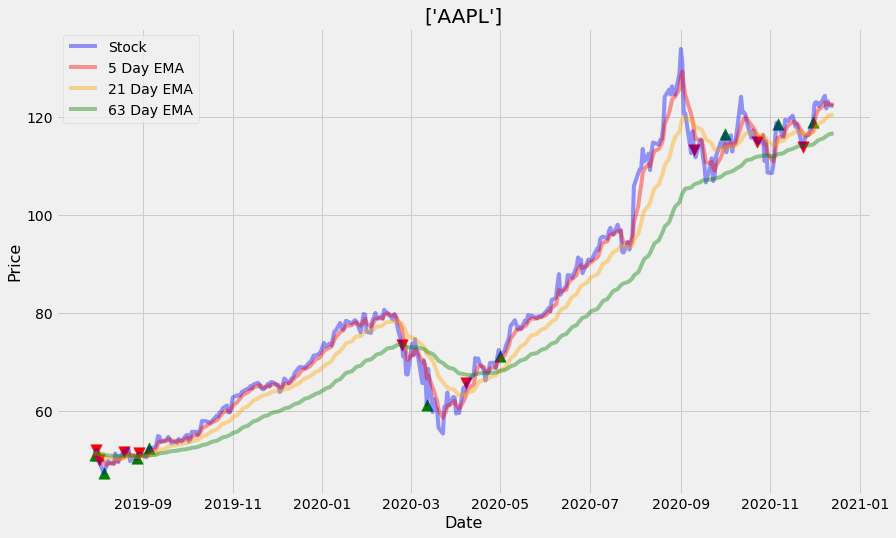


Buy Price
               0
1     50.980518
3     50.895054
5     47.210331
22    50.377613
27    52.277218
157   61.171341
192   71.235542
298  116.588860
324  118.690002
339  119.050003

Sell Price
               0
2     52.020744
4     49.818211
15    51.559048
23    51.230591
144   73.480522
176   65.567657
283  113.294540
314  114.841873
335  113.849998


In [31]:
#Add buy and sell signals to dataset
stocks_df['Buy'], stocks_df['Sell'] = buy_sell_indicators(stocks_df, ticker)
#stock_df['Sell'] = buy_sell_indicators(stocks_df, ticker)[1]

#Visualize Closing Price and Exponential Moving Averages
price_list=[]
ShortEMA_list=[]
MiddleEMA_list=[]
LongEMA_list=[]
Buy_list=[]
Sell_list=[]
for i in range(0,len(stocks_df)):
    price_list.append(stocks_df.iloc[i,0])
    ShortEMA_list.append(stocks_df.iloc[i,1])
    MiddleEMA_list.append(stocks_df.iloc[i,2])
    LongEMA_list.append(stocks_df.iloc[i,3])
    Buy_list.append(stocks_df.iloc[i,4])
    Sell_list.append(stocks_df.iloc[i,5])
     
#stocks_df.values
#print(stocks_df)
plt.figure(figsize=(13,8))
plt.title(ticker)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Price', fontsize=16)
plt.plot(stocks_df[ticker], color='blue', alpha = 0.4)
plt.plot(ShortEMA, color='red', alpha = 0.4)
plt.plot(MiddleEMA, color='orange',alpha = 0.4)
plt.plot(LongEMA, color='green', alpha = 0.4)
plt.scatter(stocks_df.index, stocks_df['Buy'], color = 'green', marker= '^', s=130, alpha = 1)
plt.scatter(stocks_df.index, stocks_df['Sell'], color = 'red', marker= 'v', s=130, alpha = 1)
plt.legend(['Stock', '5 Day EMA','21 Day EMA', '63 Day EMA'], loc='upper left')
plt.show()

Buy_list_df = pd.DataFrame(Buy_list)
Buy_list_df = Buy_list_df.dropna()
Buy_sum = Buy_list_df.sum()
Sell_list_df = pd.DataFrame(Sell_list)
Sell_list_df = Sell_list_df.dropna()
Sell_sum = Sell_list_df.sum()    

print("\nBuy Price\n",Buy_list_df)
print("\nSell Price\n",Sell_list_df)